In [ ]:
%%capture
%run '/content/drive/MyDrive/Federated_Learning/CIFAR-10/NonIID/DirichletPartition/Decentralized/Dirichlet_Requirement.ipynb'

In [1]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480

In [2]:
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
# disable_progress_bar controls the visibility of progress bars
from torch.utils.data import DataLoader
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

NUM_CLIENTS = 10
BATCH_SIZE = 32

from flwr_datasets.partitioner import DirichletPartitioner
partitioner = DirichletPartitioner(num_partitions=NUM_CLIENTS,alpha=0.05,partition_by="label",seed=42)

def load_datasets(partition_id: int):
    fds=FederatedDataset(dataset="cifar10", partitioners={"train": partitioner})
    partition=fds.load_partition(partition_id)

    print(f"Partition {partition_id} size: {len(partition)}")
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    print(f"Partition {partition_id} train size: {len(partition_train_test['train'])}")
    print(f"Partition {partition_id} test size: {len(partition_train_test['test'])}")

    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )
    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    train_batch_size = min(BATCH_SIZE, max(2, len(partition_train_test["train"])))

    trainloader = DataLoader(
        partition_train_test["train"],
        batch_size=train_batch_size,
        shuffle=True,
        drop_last=(len(partition_train_test["train"]) % train_batch_size == 1)
    )

    valloader = DataLoader(
        partition_train_test["test"],
        batch_size=BATCH_SIZE,
        drop_last=(len(partition_train_test["test"]) == 1)
    )

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)

    return trainloader, valloader, testloader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict()
    for k, v in params_dict:
        if v.size == 0:
            print(f"Warning: Parameter {k} is empty!")
            continue
        state_dict[k] = torch.tensor(v)

    net.load_state_dict(state_dict, strict=True)

In [3]:
def train(net,trainloader,epochs:int,global_params=None,mu:float=0.0,verbose=False): # adding proximal term coefficient (mu)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()

    for epoch in range(epochs):
        correct,total,epoch_loss=0,0,0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs=net(images)
            ce_loss=criterion(outputs,labels)
            # If global model parameters are given and mu is non-zero, apply FedProx algorithm
            if global_params is not None and mu>0:
                prox_term=0.0
                for param,global_param in zip(net.parameters(),global_params):
                    prox_term+=((param-global_param.to(DEVICE))**2).sum()
                ce_loss+=(mu/2)*prox_term # Adding the proximal penalty to the cross-entropy loss

            ce_loss.backward()
            optimizer.step()
            epoch_loss+=ce_loss.item()
            total+=labels.size(0)
            correct+=(outputs.argmax(dim=1)==labels).sum().item()

        if verbose:
            print(f"Epoch {epoch+1}: Train Loss = {epoch_loss:.4f}, Accuracy = {correct / total:.4f}")

In [4]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [5]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net=net
        self.trainloader=trainloader
        self.valloader=valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net,parameters)
        mu=float(config.get("mu",0.0))
        global_params=[torch.tensor(p,dtype=torch.float32).to(DEVICE) for p in parameters]
        train(self.net,self.trainloader,epochs=1,global_params=global_params,mu=mu)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [6]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)
    print(f"Context data: {context.__dict__}")

    partition_id = int(context.node_id) % NUM_CLIENTS if hasattr(context, 'node_id') else 0
    if hasattr(context, 'node_config') and 'partition_id' in context.node_config:
        partition_id = context.node_config['partition_id']

    print(f"Using partition_id: {partition_id}")
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    return FlowerClient(net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

In [7]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [8]:
from flwr.server.strategy.fedavg import FedAvg
test_accuracies = []

class CustomFedAvg(FedAvg):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            test_accuracies.append(accuracy)
            print(f"Round {server_round}: Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [9]:
def fit_config_fn(server_round: int):
    """Return training configuration dict for each round."""
    config={
        "current_round":server_round,
        "mu":0.01,
    }
    return config

strategy = CustomFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
    on_fit_config_fn=fit_config_fn,
)

In [10]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=40)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [11]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [12]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=40, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=1685) 2025-04-28 14:09:38.996320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=1685) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1685) E0000 00:00:1745849379.037371    1685 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1685) E0000 00:00:1745849379.054597    1685 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=1686) /usr/local/lib/python3.11/dist-packages/jupyter_client/co

(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 8


Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 104631.60 examples/s]
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1686) Partition 8 size: 19003
(ClientAppActor pid=1686) Partition 8 train size: 15202
(ClientAppActor pid=1686) Partition 8 test size: 3801
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 9
(ClientAppActor pid=1686) Partition 9 size: 4404
(ClientAppActor pid=1686) Partition 9 train size: 3523
(ClientAppActor pid=1686) Partition 9 test size: 881


(ClientAppActor pid=1685) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=1685) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=1685) see the appropriate new directories, set the environment variable
(ClientAppActor pid=1685) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=1685) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=1685)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1685) Partition 2 size: 2133
(ClientAppActor pid=1685) Partition 2 train size: 1706
(ClientAppActor pid=1685) Partition 2 test size: 427
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 3382686567931188604, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 4
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1686) Partition 2 size: 2133
(ClientAppActor pid=1686) Partition 2 train size: 1706
(ClientAppActor pid=1686) Partition 2 test size: 427
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 3382686567931188604, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 1: Test Accuracy: 0.3127
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 9
(ClientAppActor pid=1685) Partition 2 size: 2133
(ClientAppActor pid=1685) Partition 2 train size: 1706
(ClientAppActor pid=1685) Pa

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 8
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 2
(ClientAppActor pid=1685) Partition 8 size: 19003
(ClientAppActor pid=1685) Partition 8 train size: 15202
(ClientAppActor pid=1685) Partition 8 test size: 3801
(Cl

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 2: Test Accuracy: 0.4535
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1685) Partition 2 size: 2133
(ClientAppActor pid=1685) Partition 2 train size: 1706
(ClientAppActor pid=1685) Partition 2 test size: 427
(ClientAppActor pid=1686) Partition 4 size: 7143
(ClientAppActor pid=1686) Partition 4 train size: 5714
(ClientAppActor pid=1686) Partition 4 test size: 1429
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 7735563637842328332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=16

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1685) Partition 9 size: 4404
(ClientAppActor pid=1685) Partition 9 train size: 3523
(ClientAppActor pid=1685) Partition 9 test size: 881
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1685)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   config_records={} [repeated 2x 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 3: Test Accuracy: 0.6305
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 2
(ClientAppActor pid=1685) Partition 9 size: 4404
(ClientAppActor pid=1685) Partition 9 train size: 3523
(ClientAppActor pid=1685) Pa

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 8
(ClientAppActor pid=1686) Partition 8 size: 19003
(ClientAppActor pid=1686) Partition 8 train size: 15202
(ClientAppActor pid=1686) Partition 8 test size: 3801
(C

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 4: Test Accuracy: 0.6917
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 8
(ClientAppActor pid=1685) Partition 9 size: 4404
(ClientAppActor pid=1685) Partition 9 train size: 3523
(ClientAppActor pid=1685) P

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 7735563637842328332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 8
(ClientAppActor pid=1685) Partition 2 size: 2133
(ClientAppActor pid=1685) Partition 2 train size: 1706
(ClientAppActor pid=1685) Partition 2 test size: 427
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 5: Test Accuracy: 0.7280
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1685) Partition 9 size: 4404
(ClientAppActor pid=1685) Partition 9 train size: 3523
(ClientAppActor pid=1685) Partition 9 test size: 881
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1685)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   c

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 8
(ClientAppActor pid=1686) Partition 2 size: 2133
(ClientAppActor pid=1686) Partition 2 train size: 1706
(ClientAppActor pid=1686) Partition 2 test size: 427
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 4810290010285493207, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1686)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1686)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1686)   config_records={} [repeated 2x a

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Test Accuracy: 0.7776
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 2
(ClientAppActor pid=1686) Partition 2 size: 2133
(ClientAppActor pid=1686) Partition 2 train size: 1706
(ClientAppActor pid=1686) Pa

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1686) Partition 2 size: 2133
(ClientAppActor pid=1686) Partition 2 train size: 1706
(ClientAppActor pid=1686) Partition 2 test size: 427
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 2
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 7: Test Accuracy: 0.1803
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1685) Partition 7 size: 6226 [repeated 2x across cluster]
(ClientAppActor pid=1685) Partition 7 train size: 4980 [repeated 2x across cluster]
(ClientAppActor pid=1685) Partition 7 test size: 1246 [repeated 2x across cluster]
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)  

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 2
(ClientAppActor pid=1686) Partition 2 size: 2133
(ClientAppActor pid=1686) Partition 2 train size: 1706
(ClientAppActor pid=1686) Partition 2 test size: 427
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 8: Test Accuracy: 0.6000
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1685)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1685) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1685) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=1686) Partition 8 size: 19003 [repeated 2x across cluster]
(ClientAppActor pid=1686) Partition 8 train size: 15202 [repeated 2x across cluster]
(ClientAppActor pid=1686) Partition 8 test size: 3801 [repeated 2x across cluster]
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partiti

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1685) Partition 6 size: 570
(ClientAppActor pid=1685) Partition 6 train size: 456
(ClientAppActor pid=1685) Partition 6 test size: 114
(ClientAppActor pid=1686) Partition 8 size: 19003
(ClientAppActor pid=1686) Partition 8 train size: 15202
(ClientAppActor pid=1686) Partition 8 test size: 3801
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 7735563637842328332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1685)   array_records={}, [repeat

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 9: Test Accuracy: 0.7445
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 8
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 2
(ClientAppActor pid=1686) Partition 2 size: 2133
(ClientAppActor pid=1686) Partition 2 train size: 1706
(ClientAppActor pid=1686) P

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 15036407131136663868, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 8
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 3382686567931188604, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 4
(ClientAppActor pid=1685) Partition 8 size: 19003
(ClientAppActor pid=1685) Partition 8 train size: 15202
(ClientAppActor pid=1685) Partition 8 test size: 3801
(Cl

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 10: Test Accuracy: 0.5177
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1685) Partition 9 size: 4404
(ClientAppActor pid=1685) Partition 9 train size: 3523
(ClientAppActor pid=1685) Partition 9 test size: 881
(ClientAppActor pid=1686) Partition 8 size: 19003
(ClientAppActor pid=1686) Partition 8 train size: 15202
(ClientAppActor pid=1686) Partition 8 test size: 3801
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 3382686567931188604, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1685) Partition 9 size: 4404
(ClientAppActor pid=1685) Partition 9 train size: 3523
(ClientAppActor pid=1685) Partition 9 test size: 881
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1685)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   config_records={} [repeated 2x 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 11: Test Accuracy: 0.5024
(ClientAppActor pid=1686) Partition 9 size: 4404
(ClientAppActor pid=1686) Partition 9 train size: 3523
(ClientAppActor pid=1686) Partition 9 test size: 881
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1686)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1686)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1686)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1686) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1686) Using partition_id: 9 [repeated 2x across cluster]
(ClientAppActor pid=1685) Partition 8 size: 19003
(ClientAppActor pid=1685) Partition 8 train size: 15202
(ClientAppActor pid=1685) Partition 8 test size: 3801
(ClientAppActor pid=1686) Context data: {'run_id': 1751976

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 8
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 9
(ClientAppActor pid=1686) Partition 9 size: 4404
(ClientAppActor pid=1686) Partition 9 train size: 3523
(ClientAppActor pid=1686) Partition 9 test size: 881
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 12: Test Accuracy: 0.8048
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1685) Partition 9 size: 4404
(ClientAppActor pid=1685) Partition 9 train size: 3523
(ClientAppActor pid=1685) Partition 9 test size: 881
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1685)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 7735563637842328332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1685) Partition 2 size: 2133
(ClientAppActor pid=1685) Partition 2 train size: 1706
(ClientAppActor pid=1685) Partition 2 test size: 427
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 14759910984583793586, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1685)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   config_records={} [repeated 2x a

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 13: Test Accuracy: 0.6953
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1685)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1685)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1685)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1685) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1685) Using partition_id: 2 [repeated 3x across cluster]
(ClientAppActor pid=1686) Partition 8 size: 19003 [repeated 2x across cluster]
(ClientAppActor pid=1686) Partition 8 train size: 15202 [repeated 2x across cluster]
(ClientAppActor pid=1686) Partition 8 test size: 3801 [repeated 2x across cluster]
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 3382686567931188604, 'node_config': {'partiti

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 3382686567931188604, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 4
(ClientAppActor pid=1686) Partition 2 size: 2133
(ClientAppActor pid=1686) Partition 2 train size: 1706
(ClientAppActor pid=1686) Partition 2 test size: 427
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 7735563637842328332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1686)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1686)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1686)   config_records={} [repeated 2x ac

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 14: Test Accuracy: 0.5499
(ClientAppActor pid=1686) Partition 8 size: 19003 [repeated 2x across cluster]
(ClientAppActor pid=1686) Partition 8 train size: 15202 [repeated 2x across cluster]
(ClientAppActor pid=1686) Partition 8 test size: 3801 [repeated 2x across cluster]
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 8
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 8
(ClientAppActor pid=1685) Partition 2 size: 2133
(ClientAppActor pid=1685) Partition 2 train size: 1706
(ClientAppActor pid=1685) Partition 2 test size: 427
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 15: Test Accuracy: 0.8207
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1686) Partition 9 size: 4404
(ClientAppActor pid=1686) Partition 9 train size: 3523
(ClientAppActor pid=1686) Partition 9 test size: 881
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 7735563637842328332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1685)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   c

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1685) Partition 9 size: 4404
(ClientAppActor pid=1685) Partition 9 train size: 3523
(ClientAppActor pid=1685) Partition 9 test size: 881
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1685)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   config_records={} [repeated 2x a

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 16: Test Accuracy: 0.6118
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1685) Partition 9 size: 4404
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 2
(ClientAppActor pid=1685) Partition 9 train size: 3523
(ClientAppActor pid=1685) P

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1685) Partition 9 size: 4404
(ClientAppActor pid=1685) Partition 9 train size: 3523
(ClientAppActor pid=1685) Partition 9 test size: 881
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1685)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   config_records={} [repeated 2x 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 17: Test Accuracy: 0.7718
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 8
(ClientAppActor pid=1686) Partition 8 size: 19003
(ClientAppActor pid=1686) Partition 8 train size: 15202
(ClientAppActor pid=1686

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 7735563637842328332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 2
(ClientAppActor pid=1685) Partition 9 size: 4404
(ClientAppActor pid=1685) Partition 9 train size: 3523
(ClientAppActor pid=1685) Partition 9 test size: 881
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 18: Test Accuracy: 0.6515
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1685)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1685) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1685) Using partition_id: 8 [repeated 2x across cluster]
(ClientAppActor pid=1686) Partition 8 size: 19003 [repeated 2x across cluster]
(ClientAppActor pid=1686) Partition 8 train size: 15202 [repeated 2x across cluster]
(ClientAppActor pid=1686) Partition 8 test size: 3801 [repeated 2x across cluster]
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partit

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 3382686567931188604, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 4
(ClientAppActor pid=1685) Partition 6 size: 570
(ClientAppActor pid=1685) Partition 6 train size: 456
(ClientAppActor pid=1685) Partition 6 test size: 114
(ClientAppActor pid=1686) Partition 2 size: 2133
(ClientAppActor pid=1686) Partition 2 train size: 1706
(ClientAppActor pid=1686) Partition 2 test size: 427
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 4810290010285493207, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1686)   array_records={}, [repeated 2

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 19: Test Accuracy: 0.7039
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 9
(ClientAppActor pid=1685) Partition 2 size: 2133
(ClientAppActor pid=1685) Partition 2 train size: 1706
(ClientAppActor pid=1685) P

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 8
(ClientAppActor pid=1685) Partition 2 size: 2133
(ClientAppActor pid=1685) Partition 2 train size: 1706
(ClientAppActor pid=1685) Partition 2 test size: 427
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 20: Test Accuracy: 0.6978
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1685) Partition 9 size: 4404
(ClientAppActor pid=1685) Partition 9 train size: 3523
(ClientAppActor pid=1685) Partition 9 test size: 881
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 3382686567931188604, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1686)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1686)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1686)   

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 8
(ClientAppActor pid=1686) Partition 2 size: 2133
(ClientAppActor pid=1686) Partition 2 train size: 1706
(ClientAppActor pid=1686) Partition 2 test size: 427
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1686)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1686)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1686)   config_records={} [repeated 2x 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 21: Test Accuracy: 0.6997
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 2
(ClientAppActor pid=1685) Partition 2 size: 2133
(ClientAppActor pid=1685) Partition 2 train size: 1706
(ClientAppActor pid=1685) P

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 7735563637842328332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 8
(ClientAppActor pid=1686) Partition 8 size: 19003
(ClientAppActor pid=1686) Partition 8 train size: 15202
(ClientAppActor pid=1686) Partition 8 test size: 3801
(Cl

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 22: Test Accuracy: 0.8589
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1685) Partition 2 size: 2133
(ClientAppActor pid=1685) Partition 2 train size: 1706
(ClientAppActor pid=1685) Partition 2 test size: 427
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1685)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 8
(ClientAppActor pid=1685) Partition 8 size: 19003
(ClientAppActor pid=1685) Partition 8 train size: 15202
(ClientAppActor pid=1685) Partition 8 test size: 3801
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 7735563637842328332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1686)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1686)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1686)   config_records={} [repeated 2

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 23: Test Accuracy: 0.7036
(ClientAppActor pid=1686) Partition 7 size: 6226 [repeated 2x across cluster]
(ClientAppActor pid=1686) Partition 7 train size: 4980 [repeated 2x across cluster]
(ClientAppActor pid=1686) Partition 7 test size: 1246 [repeated 2x across cluster]
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 3382686567931188604, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 4
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 7735563637842328332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 14759910984583793586, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 6
(ClientAppActor pid=1685) Partition 2 size: 2133
(ClientAppActor pid=1685) Partition 2 train size: 1706
(ClientAppActor pid=1685) Partition 2 test size: 427
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 24: Test Accuracy: 0.8068
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1686) Partition 8 size: 19003
(ClientAppActor pid=1686) Partition 8 train size: 15202
(ClientAppActor pid=1686) Partition 8 test size: 3801
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pi

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 2
(ClientAppActor pid=1685) Partition 2 size: 2133
(ClientAppActor pid=1685) Partition 2 train size: 1706
(ClientAppActor pid=1685) Partition 2 test size: 427
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 25: Test Accuracy: 0.7891
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 8
(ClientAppActor pid=1685) Partition 8 size: 19003
(ClientAppActor pid=1685) Partition 8 train size: 15202
(ClientAppActor pid=1685) Partition 8 test size: 3801
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1686)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1686)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1686

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 8
(ClientAppActor pid=1685) Partition 8 size: 19003
(ClientAppActor pid=1685) Partition 8 train size: 15202
(ClientAppActor pid=1685) Partition 8 test size: 3801
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 14759910984583793586, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1686)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1686)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1686)   config_records={} [repeated 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 26: Test Accuracy: 0.8638
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 8
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 2
(ClientAppActor pid=1685) Partition 8 size: 19003
(ClientAppActor pid=1685) Partition 8 train size: 15202
(ClientAppActor pid=1685)

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 8
(ClientAppActor pid=1685) Partition 9 size: 4404
(ClientAppActor pid=1685) Partition 9 train size: 3523
(ClientAppActor pid=1685) Partition 9 test size: 881
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 27: Test Accuracy: 0.6810
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 2
(ClientAppActor pid=1685) Partition 9 size: 4404
(ClientAppActor pid=1685) Partition 9 train size: 3523
(ClientAppActor pid=1685) 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 2
(ClientAppActor pid=1685) Partition 2 size: 2133
(ClientAppActor pid=1685) Partition 2 train size: 1706
(ClientAppActor pid=1685) Partition 2 test size: 427
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 28: Test Accuracy: 0.7971
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1685) Partition 8 size: 19003
(ClientAppActor pid=1685) Partition 8 train size: 15202
(ClientAppActor pid=1685) Partition 8 test size: 3801
(ClientAppActor pid=1685) Partition 9 size: 4404
(ClientAppActor pid=1685) Partition 9 train size: 3523
(ClientAppActor pid=1685) Partition 9 test size: 881
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1685) Partition 9 size: 4404
(ClientAppActor pid=1685) Partition 9 train size: 3523
(ClientAppActor pid=1685) Partition 9 test size: 881
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 7735563637842328332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1685)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   config_records={} [repeated 2x a

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 29: Test Accuracy: 0.5594
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1685)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1685)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1685)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1685) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1685) Using partition_id: 8 [repeated 3x across cluster]
(ClientAppActor pid=1685) Partition 8 size: 19003 [repeated 2x across cluster]
(ClientAppActor pid=1685) Partition 8 train size: 15202 [repeated 2x across cluster]
(ClientAppActor pid=1685) Partition 8 test size: 3801 [repeated 2x across cluster]
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 14759910984583793586, 'node_config': {'parti

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 8
(ClientAppActor pid=1686) Partition 9 size: 4404
(ClientAppActor pid=1686) Partition 9 train size: 3523
(ClientAppActor pid=1686) Partition 9 test size: 881
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 7735563637842328332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1686)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1686)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1686)   config_records={} [repeated 2x a

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 30: Test Accuracy: 0.8291
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 8
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 2
(ClientAppActor pid=1686) Partition 2 size: 2133
(ClientAppActor pid=1686) Partition 2 train size: 1706
(ClientAppActor pid=1686) P

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 8
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 2
(ClientAppActor pid=1686) Partition 2 size: 2133
(ClientAppActor pid=1686) Partition 2 train size: 1706
(ClientAppActor pid=1686) Partition 2 test size: 427
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 31: Test Accuracy: 0.7945
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1686) Partition 9 size: 4404
(ClientAppActor pid=1686) Partition 9 train size: 3523
(ClientAppActor pid=1686) Partition 9 test size: 881
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1685)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 3382686567931188604, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 4
(ClientAppActor pid=1685) Partition 4 size: 7143
(ClientAppActor pid=1685) Partition 4 train size: 5714
(ClientAppActor pid=1685) Partition 4 test size: 1429
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 7735563637842328332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1686)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1686)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1686)   config_records={} [repeated 2x a

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 32: Test Accuracy: 0.5860
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1685)   array_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1685)   metric_records={}, [repeated 3x across cluster]
(ClientAppActor pid=1685)   config_records={} [repeated 3x across cluster]
(ClientAppActor pid=1685) ), 'run_config': {}} [repeated 3x across cluster]
(ClientAppActor pid=1685) Using partition_id: 8 [repeated 3x across cluster]
(ClientAppActor pid=1686) Partition 8 size: 19003 [repeated 2x across cluster]
(ClientAppActor pid=1686) Partition 8 train size: 15202 [repeated 2x across cluster]
(ClientAppActor pid=1686) Partition 8 test size: 3801 [repeated 2x across cluster]
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 3382686567931188604, 'node_config': {'partit

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1686) Partition 4 size: 7143
(ClientAppActor pid=1686) Partition 4 train size: 5714
(ClientAppActor pid=1686) Partition 4 test size: 1429
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 7735563637842328332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1685)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   config_records={} [repeated 2x 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 33: Test Accuracy: 0.5627
(ClientAppActor pid=1686) Partition 8 size: 19003 [repeated 2x across cluster]
(ClientAppActor pid=1686) Partition 8 train size: 15202 [repeated 2x across cluster]
(ClientAppActor pid=1686) Partition 8 test size: 3801 [repeated 2x across cluster]
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 8
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 8
(ClientAppActor pid=1685) Partition 2 size: 2133
(ClientAppActor pid=1685) Partition 2 train size: 1706
(ClientAppActor pid=1685) Partition 2 test size: 427
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 34: Test Accuracy: 0.8552
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1685) Partition 2 size: 2133
(ClientAppActor pid=1685) Partition 2 train size: 1706
(ClientAppActor pid=1685) Partition 2 test size: 427
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 3382686567931188604, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1685)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   c

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 8
(ClientAppActor pid=1685) Partition 8 size: 19003
(ClientAppActor pid=1685) Partition 8 train size: 15202
(ClientAppActor pid=1685) Partition 8 test size: 3801
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1686)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1686)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1686)   config_records={} [repeated 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 35: Test Accuracy: 0.7906
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 8
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 9
(ClientAppActor pid=1685) Partition 8 size: 19003
(ClientAppActor pid=1685) Partition 8 train size: 15202
(ClientAppActor pid=1685

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 8
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 9
(ClientAppActor pid=1686) Partition 9 size: 4404
(ClientAppActor pid=1686) Partition 9 train size: 3523
(ClientAppActor pid=1686) Partition 9 test size: 881
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 36: Test Accuracy: 0.7712
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1686) Partition 8 size: 19003
(ClientAppActor pid=1686) Partition 8 train size: 15202
(ClientAppActor pid=1686) Partition 8 test size: 3801
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 14759910984583793586, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1685)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1685) Partition 9 size: 4404
(ClientAppActor pid=1685) Partition 9 train size: 3523
(ClientAppActor pid=1685) Partition 9 test size: 881
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 7735563637842328332, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1685)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   config_records={} [repeated 2x a

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 37: Test Accuracy: 0.7809
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 9
(ClientAppActor pid=1686) Partition 9 size: 4404
(ClientAppActor pid=1686) Partition 9 train size: 3523
(ClientAppActor pid=1686) 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 2
(ClientAppActor pid=1685) Partition 8 size: 19003
(ClientAppActor pid=1685) Partition 8 train size: 15202
(ClientAppActor pid=1685) Partition 8 test size: 3801
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 16375995759392111492, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 2
(Cl

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 38: Test Accuracy: 0.7094
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1685)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1685) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1685) Using partition_id: 2 [repeated 2x across cluster]
(ClientAppActor pid=1685) Partition 8 size: 19003
(ClientAppActor pid=1685) Partition 8 train size: 15202
(ClientAppActor pid=1685) Partition 8 test size: 3801
(ClientAppActor pid=1685) Partition 2 size: 2133
(ClientAppActor pid=1685) Partition 2 train size: 1706
(ClientAppActor pid=1685) Partition 2 test size: 427
(ClientAppActor pid=1685) Context data: {'run_id': 17519768

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1685) Partition 9 size: 4404
(ClientAppActor pid=1685) Partition 9 train size: 3523
(ClientAppActor pid=1685) Partition 9 test size: 881
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 9164069515379899242, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1685)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1685)   config_records={} [repeated 2x a

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 39: Test Accuracy: 0.7803
(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 8
(ClientAppActor pid=1685) Partition 9 size: 4404
(ClientAppActor pid=1685) Partition 9 train size: 3523
(ClientAppActor pid=1685) 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1685) Context data: {'run_id': 17519768168359564718, 'node_id': 16227600606090675759, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1685)   array_records={},
(ClientAppActor pid=1685)   metric_records={},
(ClientAppActor pid=1685)   config_records={}
(ClientAppActor pid=1685) ), 'run_config': {}}
(ClientAppActor pid=1685) Using partition_id: 9
(ClientAppActor pid=1686) Context data: {'run_id': 17519768168359564718, 'node_id': 10725069351455319208, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1686)   array_records={},
(ClientAppActor pid=1686)   metric_records={},
(ClientAppActor pid=1686)   config_records={}
(ClientAppActor pid=1686) ), 'run_config': {}}
(ClientAppActor pid=1686) Using partition_id: 8
(ClientAppActor pid=1685) Partition 9 size: 4404
(ClientAppActor pid=1685) Partition 9 train size: 3523
(ClientAppActor pid=1685) Partition 9 test size: 881
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 40 round(s) in 20025.49s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06763015903391731
INFO :      		round 2: 0.06806197198819769
INFO :      		round 3: 0.04049025845473403
INFO :      		round 4: 0.03498370843569475
INFO :      		round 5: 0.028599156407599455
INFO :      		round 6: 0.022593369339394268
INFO :      		round 7: 0.11739040111675116
INFO :      		round 8: 0.048034223865965515
INFO :      		round 9: 0.02630186970202882
INFO :      		round 10: 0.06501806533944396
INFO :      		round 11: 0.06678938580783637
INFO :      		round 12: 0.021477564823876815
INFO :      		round 13: 0.039816048985876575
INFO :      		round 14: 0.06015877077549386
INFO :      		round 15: 0.017605372184534087
INFO :      		round 16: 0.0414053402502238
INFO :      		round 17: 0.0255234774918994
INFO :      		round 18: 0.0372751159661434
INFO :      		round 1

Round 40: Test Accuracy: 0.5673


In [13]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(test_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")


===== SUMMARY OF TEST ACCURACIES =====
Round 1: 0.3127
Round 2: 0.4535
Round 3: 0.6305
Round 4: 0.6917
Round 5: 0.7280
Round 6: 0.7776
Round 7: 0.1803
Round 8: 0.6000
Round 9: 0.7445
Round 10: 0.5177
Round 11: 0.5024
Round 12: 0.8048
Round 13: 0.6953
Round 14: 0.5499
Round 15: 0.8207
Round 16: 0.6118
Round 17: 0.7718
Round 18: 0.6515
Round 19: 0.7039
Round 20: 0.6978
Round 21: 0.6997
Round 22: 0.8589
Round 23: 0.7036
Round 24: 0.8068
Round 25: 0.7891
Round 26: 0.8638
Round 27: 0.6810
Round 28: 0.7971
Round 29: 0.5594
Round 30: 0.8291
Round 31: 0.7945
Round 32: 0.5860
Round 33: 0.5627
Round 34: 0.8552
Round 35: 0.7906
Round 36: 0.7712
Round 37: 0.7809
Round 38: 0.7094
Round 39: 0.7803
Round 40: 0.5673



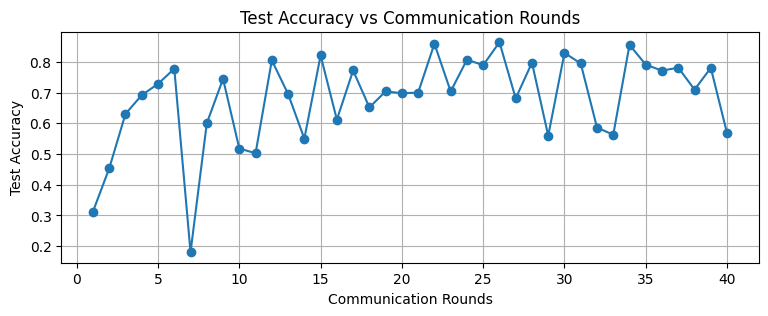

In [14]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.savefig('accuracy_vs_rounds.png')
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()